# 1.4 Friend recommendation in personalized networks

In [1]:
library(igraph)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



## Question 16: What is $\left|N_r\right|$?

In [2]:
# load the graph from the edgelist
g.fb <- read.graph("./facebook_combined.txt", format = "edgelist", directed = FALSE)

# get the personalized network of node ID 415
personal.network <- induced.subgraph(g.fb, c(415, neighbors(g.fb, 415)))

In [3]:
# # assign id to each node
# V(personal.network)$vid <- seq(vcount(personal.network),1)

# # find out the Node Id 415 (center.node)
# v.id <- V(personal.network)$vid[degree(personal.network)==max(degree(personal.network))]
# center.node <- get.vertex.attribute(personal.network, "vid", index = v.id)


In [4]:
# find Node id 415 in the network
center.node <- V(personal.network)[degree(personal.network)==max(degree(personal.network))]

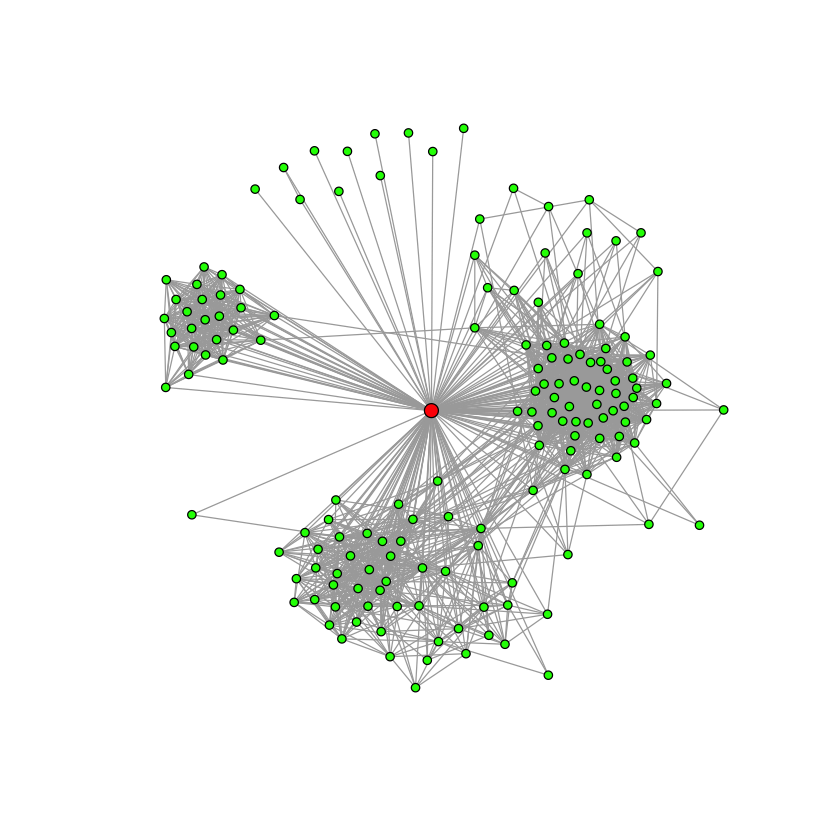

In [5]:
# plot the personalized network of Node id 415
vertexvector <- rep(3,vcount(personal.network))
vertexvector[center.node] <- 5
vertexcolor <- rep("green",vcount(personal.network))
vertexcolor[center.node] <- "red"
plot.igraph(personal.network,vertex.size=vertexvector,vertex.label=NA,vertex.color=vertexcolor)

In [6]:
# # get the N_r list
# N_r <- V(personal.network)$vid[degree(personal.network)== 24]

# # visualize these nodes in graph
# N_r <- get.vertex.attribute(personal.network, "vid", index = N_r)

In [7]:
N_r <- V(personal.network)[degree(personal.network)== 24]

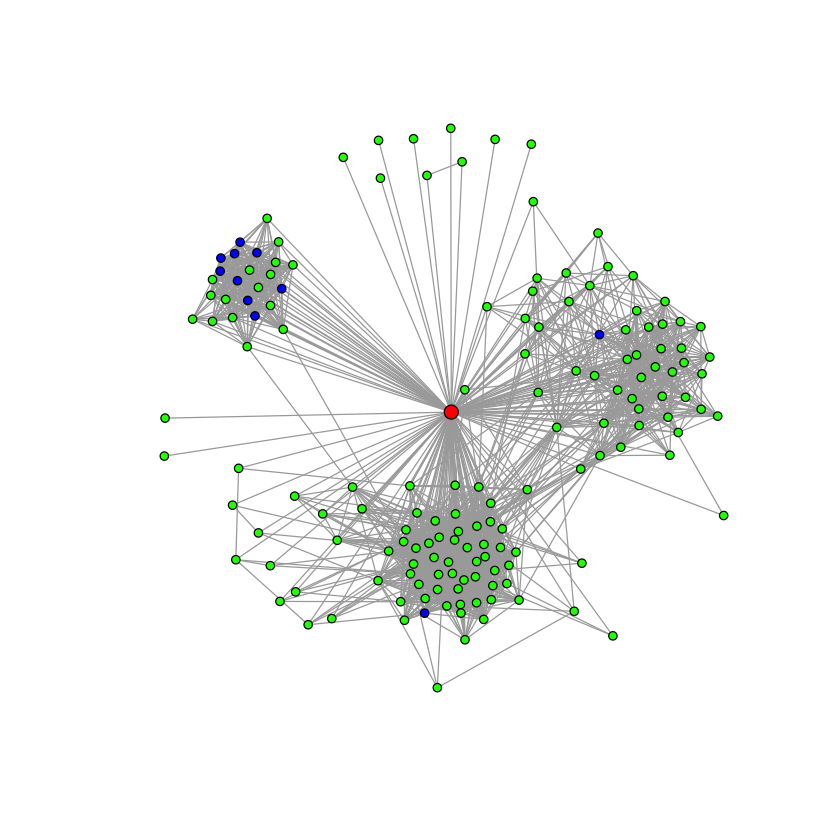

In [8]:
vertexcolor[N_r] = "blue"
plot.igraph(personal.network,vertex.size=vertexvector,vertex.label =NA,vertex.color=vertexcolor)


## Question 17: Compute the average accuracy of the friend recommendation algorithm that uses:
* Common Neighbors measure 
* Jaccard measure
* Adamic Adar measure

Based on the average accuracy values, which friend recommendation algorithm is the best?

### Functions needed for solving question 17:

#### Function 1: 25%

In [9]:
# 25% to delete an edge
is.del.edge <- function() {
    res <- sample(c(1,2,3,4),1)
    res == 1
}

#### Function 2: Copy the network

In [10]:
# copy the network
network.copy <- function(network) {
    induced_subgraph(network, V(network))
}

#### Function 3: Get the new network after deleting the edges

In [11]:
# get the new network after deleting the edges
# graph - personal.network.copy
# node - the nodes in N_r list
get.new.network <- function(network, node) {
    node.neighbors <- neighbors(network, node)   
    for (i in 1:length(node.neighbors)) {
        if (is.del.edge()) {
            network <- delete_edges(network, E(network, c(node, node.neighbors[i])))
        }
    }
    network
}

#### Function 4: Get $R_i$ list

In [12]:
# get R_i list
# network - original personal network
# new.network - copeid personal network
# node - the node in N_r list
get.R_i <- function(network, new.network, node) {
    original.neighbors <- neighbors(network, node)
    new.neighbors <- neighbors(new.network, node)
    setdiff(original.neighbors, new.neighbors)
}

#### Function 5: Common Neighbors

In [13]:
# new.network - copied personal network
# node_i - the nodes in N_r list
# node_j - the nodes in personal network
# node_j is not a neighbor of node_i
common.neighbors <- function(new.network, node_i, node_j) {
    S_i <- neighbors(new.network, node_i)
    S_j <- neighbors(new.network, node_j)
    length(intersect(S_i, S_j))
}

#### Function 6: Jaccard Measure

In [14]:
# new.network - copied personal network
# node_i - the nodes in N_r list
# node_j - the nodes in personal network
# node_j is not a neighbor of node_i
jaccard.measure <- function(new.network, node_i, node_j) {
    S_i <- neighbors(new.network, node_i)
    S_j <- neighbors(new.network, node_j)
    length(intersect(S_i, S_j)) / length(union(S_i, S_j))
}

#### Function 7: Adamic-Adar Measure

In [15]:
adamic.adar.measure <- function(new.network, node_i, node_j) {
    S_i <- neighbors(new.network, node_i)
    S_j <- neighbors(new.network, node_j)
    k <- intersect(S_i, S_j)
    res <- 0
    for (node_k in k) {
        S_k <- neighbors(new.network, node_k)
        res <- res + 1 / log(length(S_k))
    }
    res
}

#### Function 8: Get $P_i$ list

In [16]:
# get P_i list
# new.network - copied personal network
# node i - the nodes in N_r list
get.P_i <- function(new.network, node_i, R_i, algo.name) {
    S_i <- neighbors(new.network, node_i)
    
    # get the non-neighbor nodes list
    not.S_i <- setdiff(V(new.network), S_i)
    
    # exclude itself from the non-neighbor nodes list
    not.S_i <- setdiff(not.S_i, node_i)
    measure.res <- rep(0, length(not.S_i))
    if (algo.name == "common neighbors") {
        for (i in 1:length(not.S_i)) {
            measure.res[i] <- common.neighbors(new.network, node_i, not.S_i[i])
        }
    } else if (algo.name == "jaccard measure") {
        for (i in 1:length(not.S_i)) {
            measure.res[i] <- jaccard.measure(new.network, node_i, not.S_i[i])
        }        
    } else if (algo.name == "adamic adar measure") {
        for (i in 1:length(not.S_i)) {
            measure.res[i] <- adamic.adar.measure(new.network, node_i, not.S_i[i])
        }        
    }
    len <- length(R_i)
    
    # find out the highest |R_i| score from not.S_i list
    measure.res.df <- data.frame(idx = not.S_i, measure = measure.res)
    measure.res.df <- measure.res.df[order(measure.res.df$measure, decreasing = TRUE),]
    measure.res.df <- measure.res.df[1:len,]
    
    # get the node ids of thest nodes
    P_i <- measure.res.df$idx
    P_i
}

#### Fucntion 9: Accuracy

In [17]:
accuracy <- function(P_i, R_i) {
    length(intersect(P_i, R_i)) / length(R_i)
}

#### Script of question 17 below

In [18]:
# get the integer type Node Id in N_r
# so that the node id can be used in both network and network.copy 
node.idx <- rep(0, length(N_r))
for (i in 1:length(N_r)) {
    node.idx[i] <- N_r[i]
}

In [28]:
iteration <- 10
algos <- c("common neighbors", "jaccard measure", "adamic adar measure")
# algos <- c("adamic adar measure")
# iterate 10 times 
for (h in 1:10) {
    cat("================= round", h, "=================\n")
    final.acc <- rep(0, length(algos))
    for (k in 1:length(algos)){
        for (i in 1:length(node.idx)) {
            user.acc <- 0
            for (j in 1:10) {
                personal.copy <- network.copy(personal.network)
                personal.copy <- get.new.network(personal.copy, node.idx[i])
                R_i <- get.R_i(personal.network, personal.copy, node.idx[i])
                P_i <- get.P_i(personal.copy, node.idx[i], R_i, algos[k])
                user.acc <- user.acc + accuracy(P_i, R_i)
            }
            
            # Average accuracy of each node in N_r
            user.acc <- user.acc / iteration
            final.acc[k] <- final.acc[k] + user.acc
        }
        
        # Average accuracy of each algorithm
        final.acc[k] <- final.acc[k] / length(node.idx)
        cat("The average accuracy of", algos[k], "is", final.acc[k], "\n")    
    }  
}


================= round 1 =================
The average accuracy of common neighbors is 0.8487698 
The average accuracy of jaccard measure is 0.7867424 
The average accuracy of adamic adar measure is 0.8140689 
================= round 2 =================
The average accuracy of common neighbors is NaN 
The average accuracy of jaccard measure is 0.8053639 
The average accuracy of adamic adar measure is 0.8149744 
================= round 3 =================
The average accuracy of common neighbors is 0.8322868 
The average accuracy of jaccard measure is 0.8102161 
The average accuracy of adamic adar measure is 0.8258297 
================= round 4 =================
The average accuracy of common neighbors is NaN 
The average accuracy of jaccard measure is 0.8137725 
The average accuracy of adamic adar measure is 0.8214551 
================= round 5 =================
The average accuracy of common neighbors is 0.8453857 
The average accuracy of jaccard measure is 0.7932581 
The average acc

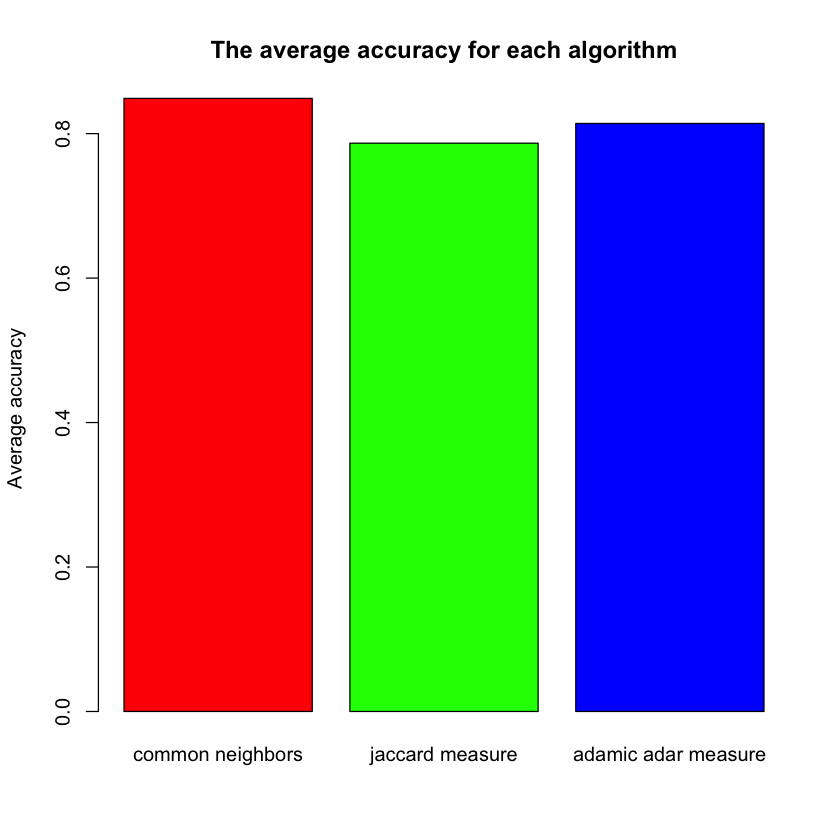

In [31]:
# take round 1 as example
final.acc <- c(0.8487698, 0.7867424, 0.8140689)
barplot(final.acc, main = "The average accuracy for each algorithm", 
         horiz = FALSE, ylab = "Average accuracy",names.arg = algos, col = c("red", "green", "blue"))